In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
df = pd.read_csv('data/raw/SpotifyFeatures.csv')

In [3]:
df['popular'] = np.where(df['popularity'] >= 50, 1, 0)

In [4]:
(df['popular'].value_counts(normalize=True) * 100).round(2)

popular
0    63.47
1    36.53
Name: proportion, dtype: float64

In [5]:
df.drop(columns=['artist_name', 'track_name', 'track_id', 'popularity', 'liveness'], inplace=True)

In [6]:
df.head()

,genre,acousticness,danceability,duration_ms,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,popular
0,Movie,0.611,0.389,99373,0.910,0.000,C#,-1.828,Major,0.0525,166.969,4/4,0.814,0
1,Movie,0.246,0.590,137373,0.737,0.000,F#,-5.559,Minor,0.0868,174.003,4/4,0.816,0
2,Movie,0.952,0.663,170267,0.131,0.000,C,-13.879,Minor,0.0362,99.488,5/4,0.368,0
3,Movie,0.703,0.240,152427,0.326,0.000,C#,-12.178,Major,0.0395,171.758,4/4,0.227,0
4,Movie,0.950,0.331,82625,0.225,0.123,F,-21.150,Major,0.0456,140.576,4/4,0.390,0


In [7]:
num_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']
num = df[num_cols]

In [8]:
cat_cols = ['genre', 'key', 'mode', 'time_signature']
cat = df[cat_cols]

In [9]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(cat)
encoded_cols = encoder.get_feature_names_out(cat_cols)
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoded_cols, index=df.index)
df_encoded = pd.concat([df.drop(columns=cat_cols), cat_encoded_df], axis=1)


In [10]:
df_encoded.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,popular,...,key_F#,key_G,key_G#,mode_Major,mode_Minor,time_signature_0/4,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4
0,0.611,0.389,99373,0.910,0.000,-1.828,0.0525,166.969,0.814,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.246,0.590,137373,0.737,0.000,-5.559,0.0868,174.003,0.816,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.952,0.663,170267,0.131,0.000,-13.879,0.0362,99.488,0.368,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.703,0.240,152427,0.326,0.000,-12.178,0.0395,171.758,0.227,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.950,0.331,82625,0.225,0.123,-21.150,0.0456,140.576,0.390,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
X = df_encoded.drop(columns='popular')
y = df_encoded['popular'] 


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,     
    stratify=y,        
    random_state=45678
)

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svm.LinearSVC())
])
pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001


Acurácia no teste: 0.852


<Axes: >

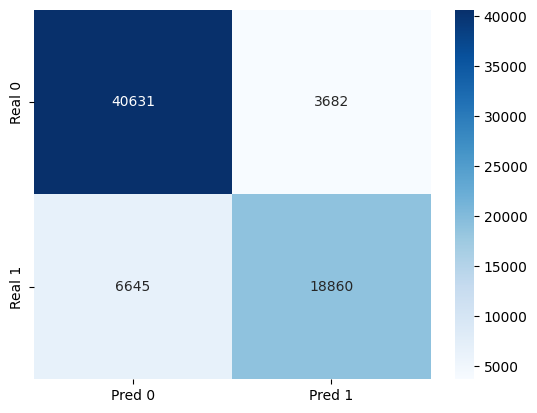

In [14]:
y_pred = pipeline.predict(X_test)
print(f'Acurácia no teste: {accuracy_score(y_test, y_pred):.3f}')
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Real 0', 'Real 1'], columns=['Pred 0', 'Pred 1'])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')



In [15]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state=45678, n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(f'Acurácia Random Forest: {accuracy_score(y_test, rf_pred):.3f}')
rf_cm = confusion_matrix(y_test, rf_pred)
pd.DataFrame(rf_cm, index=['Real 0', 'Real 1'], columns=['Pred 0', 'Pred 1'])


Acurácia Random Forest: 0.856


,Pred 0,Pred 1
Real 0,40427,3886
Real 1,6202,19303


In [16]:
dt_clf = DecisionTreeClassifier(random_state=45678)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print(f'Acurácia Decision Tree: {accuracy_score(y_test, dt_pred):.3f}')
dt_cm = confusion_matrix(y_test, dt_pred)
pd.DataFrame(dt_cm, index=['Real 0', 'Real 1'], columns=['Pred 0', 'Pred 1'])


Acurácia Decision Tree: 0.787


,Pred 0,Pred 1
Real 0,36771,7542
Real 1,7339,18166


In [17]:
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45678,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(f'Acurácia XGBoost: {accuracy_score(y_test, xgb_pred):.3f}')
xgb_cm = confusion_matrix(y_test, xgb_pred)
pd.DataFrame(xgb_cm, index=['Real 0', 'Real 1'], columns=['Pred 0', 'Pred 1'])


Acurácia XGBoost: 0.856


,Pred 0,Pred 1
Real 0,40324,3989
Real 1,6042,19463
